#  Stock Prediction using LSTM - Long Short-Term Memory

In [52]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow import keras


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [53]:
# Define the ticker
ticker = 'TSLA'

# Download TSLA stock data up to today
tsla_data = yf.download(ticker, start="2017-01-01")

# Print the retrieved data
print(tsla_data)

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2017-01-03   14.466000   14.688667   14.064000   14.324000   88849500
2017-01-04   15.132667   15.200000   14.287333   14.316667  168202500
2017-01-05   15.116667   15.165333   14.796667   15.094667   88675500
2017-01-06   15.267333   15.354000   15.030000   15.128667   82918500
2017-01-09   15.418667   15.461333   15.200000   15.264667   59692500
...                ...         ...         ...         ...        ...
2025-02-14  355.839996  362.000000  347.500000  360.619995   68277300
2025-02-18  354.109985  359.100006  350.019989  355.010010   51631700
2025-02-19  360.559998  367.339996  353.670013  354.000000   67094400
2025-02-20  354.399994  362.299988  348.000000  361.510010   45965400
2025-02-21  337.799988  354.980011  334.420013  353.440002   73787800

[2046 rows x 5 colu

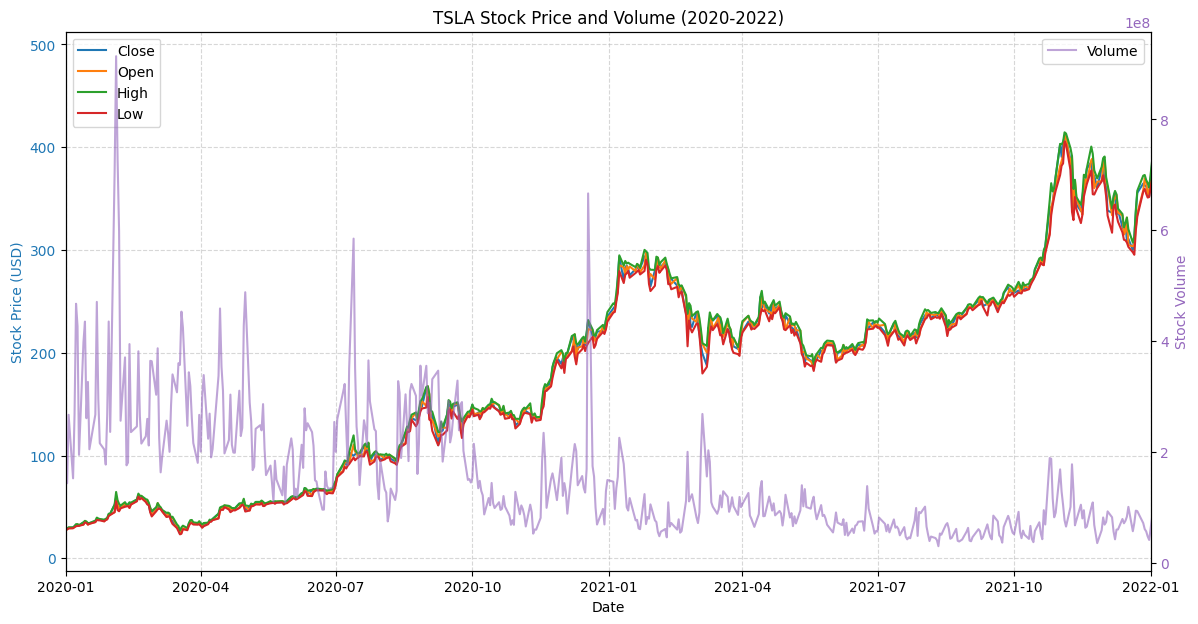

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Define color palette
colors = sns.color_palette("tab10", 5)

# Plot stock prices on left y-axis
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price (USD)", color=colors[0])
ax1.plot(tsla_data.index, tsla_data['Close'], label='Close', color=colors[0])
ax1.plot(tsla_data.index, tsla_data['Open'], label='Open', color=colors[1])
ax1.plot(tsla_data.index, tsla_data['High'], label='High', color=colors[2])
ax1.plot(tsla_data.index, tsla_data['Low'], label='Low', color=colors[3])
ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.set_xlim([datetime(2020, 1, 1), datetime(2022, 1, 1)])
ax1.legend(loc="upper left")

# Create second y-axis for volume
ax2 = ax1.twinx()
ax2.set_ylabel("Stock Volume", color=colors[4])
ax2.plot(tsla_data.index, tsla_data['Volume'], label='Volume', color=colors[4], alpha=0.6)
ax2.tick_params(axis='y', labelcolor=colors[4])
ax2.legend(loc="upper right")

# Title and grid
plt.title("TSLA Stock Price and Volume (2020-2022)")
ax1.grid(True, linestyle="--", alpha=0.5)

plt.show()

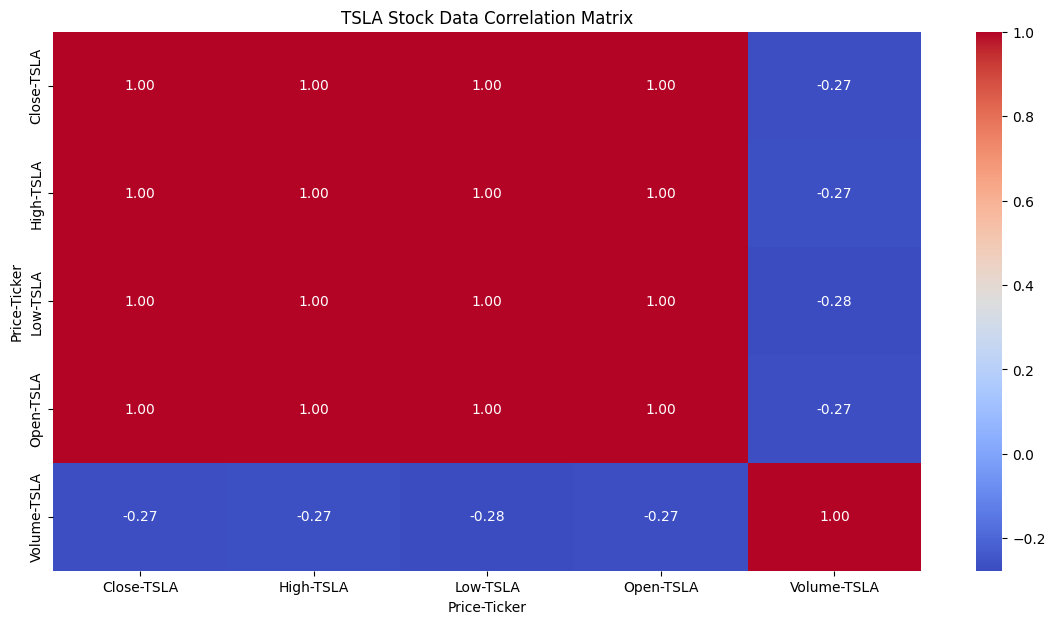

In [55]:
# Plot the Correlation Matrix
plt.figure(figsize=(14, 7))
sns.heatmap(tsla_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("TSLA Stock Data Correlation Matrix")
plt.show()

In [56]:
# Prepare for the LSTM Model
# Define the number of days to use for predictions
n_days = 5

# Create a new DataFrame to store the shifted values
data_shift = tsla_data[['Close']].copy()
for i in range(1, n_days + 1):
    data_shift[f'Close-{i}'] = data_shift['Close'].shift(i)

# Drop the rows with missing values
data_shift.dropna(inplace=True)

In [57]:
# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_shift)

In [58]:
# Create the feature matrix (X) and target vector (y)
X = data_scaled[:, 1:]
y = data_scaled[:, 0]

# Split the data into training and testing sets
split = int(0.8 * len(data_scaled))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape the data for the LSTM model
X_train = X_train.reshape(X_train.shape[0], n_days, 1)
X_test = X_test.reshape(X_test.shape[0], n_days, 1)

# Build the LSTM Model
model = keras.Sequential([
    keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/3


/workspaces/time-series-analysis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7987 - val_loss: 0.1236
Epoch 2/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0223 - val_loss: 0.0162
Epoch 3/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_loss: 0.0123


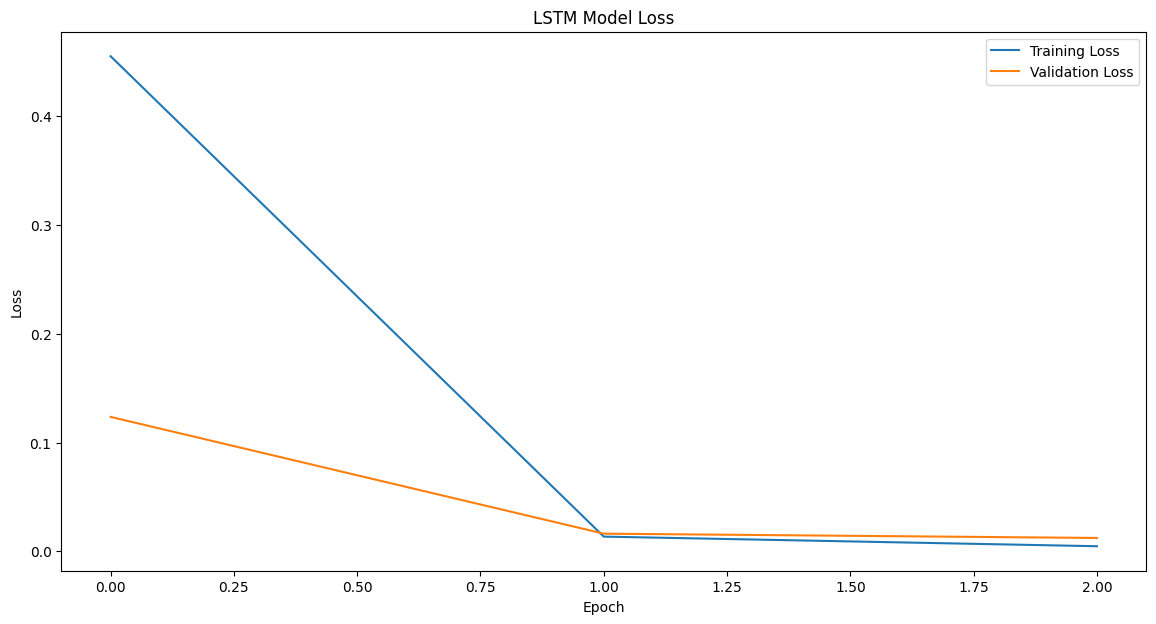

In [59]:
# Plot the Loss Curves
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


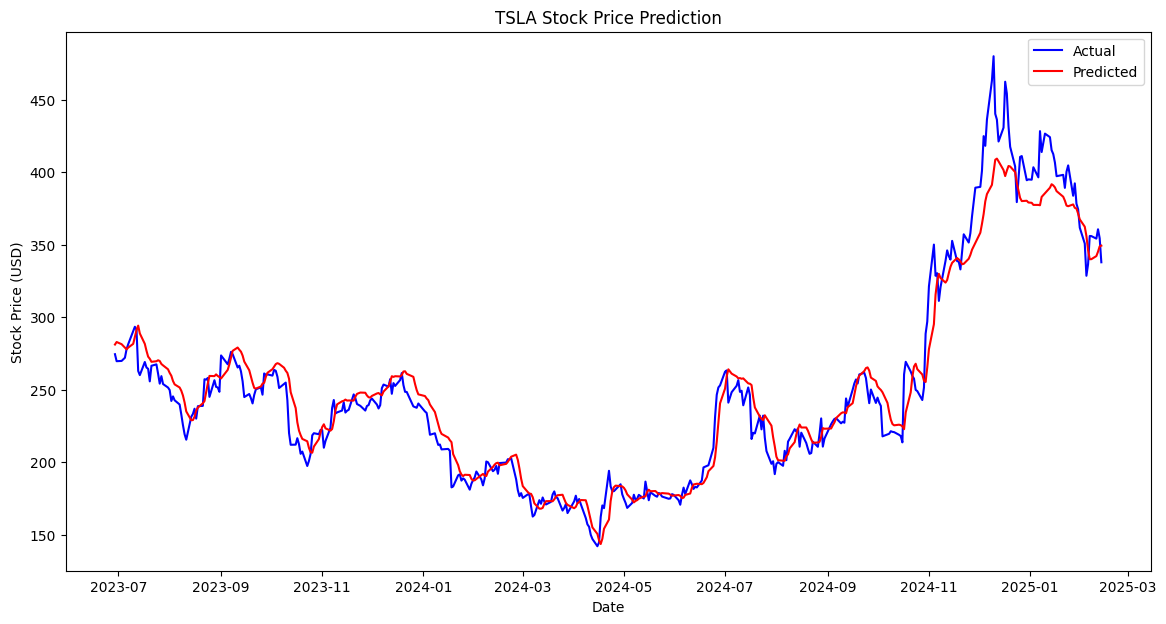

In [62]:
# Make Predictions
y_pred = model.predict(X_test)

# Ensure proper feature dimensions for inverse transformation
num_features = scaler.mean_.shape[0]  # Get the original feature count

# Prepare arrays with the correct shape
y_test_inv = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], num_features - 1))])
)[:, 0]

y_pred_inv = scaler.inverse_transform(
    np.hstack([y_pred, np.zeros((y_pred.shape[0], num_features - 1))])
)[:, 0]

# Create a DataFrame of actual and predicted values
results = pd.DataFrame({'Actual': y_test_inv, 'Predicted': y_pred_inv})
results.index = tsla_data.index[split:split + len(y_test)]

# Plot Actual vs. Predicted Values
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Actual'], label='Actual', color='blue')
plt.plot(results.index, results['Predicted'], label='Predicted', color='red')
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/tmp/ipykernel_12660/2525590820.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_future[0, -1, 0] = y_pred_future  # Add the new prediction at the end


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


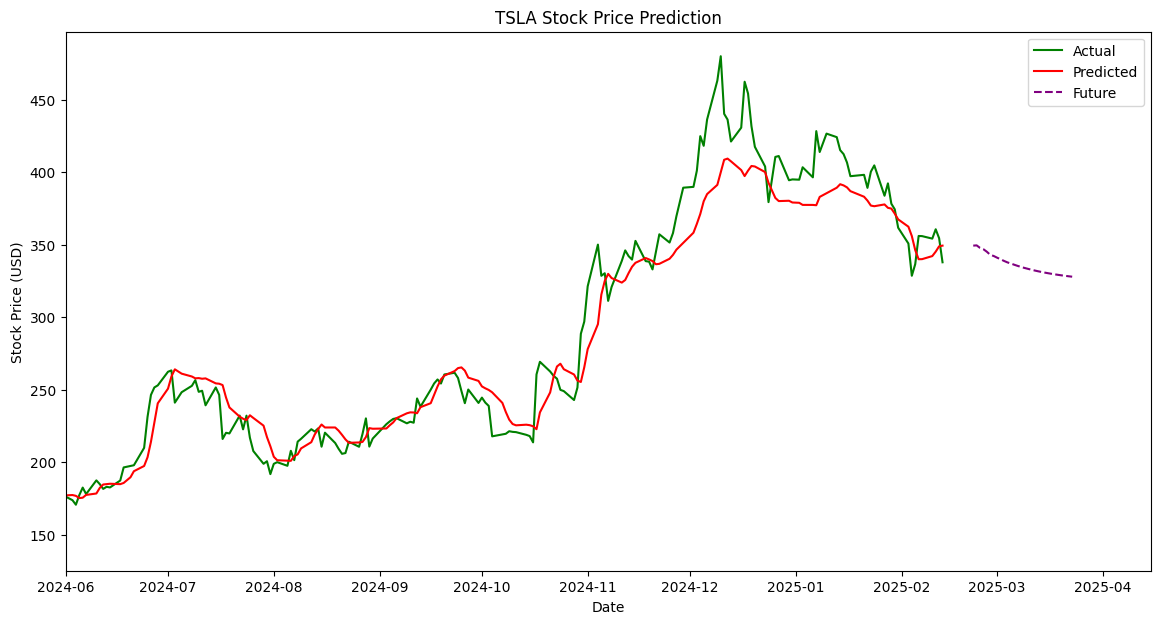

In [69]:
from datetime import timedelta

# Number of future days to predict
n_future = 30
n_days = 5  # Ensure this matches the model's training setup

# Generate future dates
future_dates = [tsla_data.index[-1] + timedelta(days=i) for i in range(1, n_future + 1)]
future_dates = np.array(future_dates)

# Prepare the dataset for future predictions
future_predictions = tsla_data[['Close']].copy()
for i in range(1, n_days + 1):
    future_predictions[f'Close-{i}'] = future_predictions['Close'].shift(i)

# Drop NaN values (caused by shifting)
future_predictions = future_predictions.dropna()

# Scale the last `n_days` data points
future_scaled = scaler.transform(future_predictions)

# Ensure `X_future` has the correct shape (last `n_days` timesteps)
X_future = future_scaled[-1, 1:].reshape(1, n_days, 1)  # Use only the last row as input

# Predict future stock prices
future_pred = []
for i in range(n_future):
    y_pred_future = model.predict(X_future)
    future_pred.append(y_pred_future[0, 0])
    
    # Update the feature matrix for rolling predictions
    X_future = np.roll(X_future, shift=-1, axis=1)  # Shift left
    X_future[0, -1, 0] = y_pred_future  # Add the new prediction at the end

# Inverse transform the predictions
future_pred_inv = scaler.inverse_transform(
    np.hstack([np.array(future_pred).reshape(-1, 1), np.zeros((n_future, scaler.mean_.shape[0] - 1))])
)[:, 0]

# Create a DataFrame for future predictions
future_results = pd.DataFrame({'Predicted': future_pred_inv}, index=future_dates)

# Plotting
plt.figure(figsize=(14, 7))
# plt.plot(tsla_data.index, tsla_data['Close'], label='Historical', color='blue')
plt.plot(results.index, results['Actual'], label='Actual', color='green')
plt.plot(results.index, results['Predicted'], label='Predicted', color='red')
plt.plot(future_results.index, future_results['Predicted'], label='Future', color='purple', linestyle="dashed")
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
xlim = [datetime(2024, 6, 1), datetime(2025,4 , 15)]
plt.xlim(xlim)
plt.legend()
plt.show()
